In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '../../..'))

# basics
from PySDM.physics import si
from PySDM.physics import formulae as phys
import numpy as np
from matplotlib import pyplot
from PySDM.physics.constants import rho_w

# sampling
from PySDM.initialisation.spectra import Exponential
from PySDM.initialisation.spectral_sampling import ConstantMultiplicity

# environment
from PySDM import Builder
from PySDM.environments import Box

# dynamics
from PySDM.dynamics import Coalescence
from PySDM.dynamics.coalescence.kernels import SpecifiedEff
from PySDM.backends import CPU
from PySDM.products.state import ParticlesVolumeSpectrum, KMoments

In [4]:
###### SPECIFY SETUP ########
# Kernel Constants: none to specify for hydrodynamic
A = 1
B = 0
D1 = -27
D2 = 1.64
E1 = 0
E2 = 0 
F1 = 0
F2 = 0
G1 = 0 
G2 = 0
G3 = 0
Mf = 0
Mg = 0
kernel = SpecifiedEff(A=A, B=B, D1=D1, D2=D2, E1=E1, E2=E2, F1=F1, F2=F2, G1=G1, G2=G2, G3=G3, Mf=Mf, Mg=Mg)

# Simulation constants
n_sd = 2 ** 13           # number of superdroplets
n_part = 239 / si.cm**3  # particle density
dv = 1e1 * si.metres**3  # box size
norm_factor = n_part * dv # number of particles to represent
dt = 1 * si.seconds
output_steps = [200 * i for i in range(10)]

# initial distribution
X0 = 4 / 3 * np.pi * (10 * si.micrometres) ** 3


###### INITIALISE ########
# initial distribution
initial_spectrum = Exponential(norm_factor=norm_factor, scale=X0)
attributes = {}
attributes['volume'], attributes['n'] = ConstantMultiplicity(spectrum=initial_spectrum).sample(n_sd)

# build the superdroplets
builder = Builder(n_sd=n_sd, backend=CPU)
builder.set_environment(Box(dt=dt, dv=dv))
builder.add_dynamic(Coalescence(kernel=kernel))
products = [ParticlesVolumeSpectrum(), KMoments()]
core = builder.build(attributes, products)

# plot initial distribution
radius_bins_edges = np.logspace(np.log10(3.94 * si.um), np.log10(220 * si.um), num=100, endpoint=True)

In [12]:
###### RUN AND OUTPUT MOMENTS ######
for step in output_steps:
    core.run(step - core.n_steps)
    print(core.products['M0-Mk'].get(3))

[2.38995046e+09 1.00096977e-05 8.37814975e-20]
[2.36413130e+09 1.00096977e-05 8.70461113e-20]
[2.33203968e+09 1.00096977e-05 9.29025585e-20]
[2.30140677e+09 1.00096977e-05 9.77857490e-20]
[2.26814818e+09 1.00096977e-05 1.04737527e-19]
[2.22599146e+09 1.00096977e-05 1.14408780e-19]
[2.18150081e+09 1.00096977e-05 1.26214525e-19]
[2.13759365e+09 1.00096977e-05 1.44617591e-19]
[2.08493421e+09 1.00096977e-05 1.80660024e-19]
[2.02078746e+09 1.00096977e-05 2.47239706e-19]


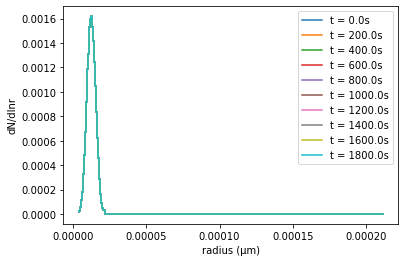

In [5]:
###### RUN AND PLOT #######
# step forward in time and plot
vals = {}
for step in output_steps:
    core.run(step - core.n_steps)
    vals[step] = core.products['dv/dlnr'].get(radius_bins_edges)
    vals[step][:] *= rho_w
    pyplot.step(x=radius_bins_edges[:-1],
                y=vals[step],#/particles.products['Mk'].get(0),
                where='post', label=f"t = {step*dt}s")

pyplot.xlabel('radius (µm)')
pyplot.ylabel("dN/dlnr")
pyplot.legend()